In [92]:
# Radar signal simulator
# ECE 435/535 Winter 2020
# -------------------
# Kimi Owens 
# Date: February 23, 2020
# -------------------
# Description of add ons 

'''
Method: -- this is a script..
1 - Create a pulse train from Transmitter
2 - Generate a list of targets, (Range, RCS)
3 - Generate return pulses for each of the targets into a single train
4 - Attenuate 1 to reasonable power level
5 - Add 3+4
6 - Add AGWN to 5
7 - Apply detection method
'''

from matplotlib import pyplot as plt
import numpy as np
import scipy.signal as sig

# Custom libraries
import pulsetrain as pt
import pulsenoise as pn
import detection as det

# Student Libary
import owens as kdo # Intials (Kimi D. Owens)


## Student Custom Library 

In [112]:
def myfuction(var1, var2='1942', var3='Chain Home'):
    print(var1, var2, var3)
    x = 42
    return x, var1

# usage
derp0, derp1 = myfuction(23,'1939')
print('\n================')
print(derp0, derp1)

def noise(signal):
    ''' 
    Fuction to detect/generate new noise floor after gating and summing
    '''
    average = np.average(signal)
    return average

def probability(signal, noise, num_obvs):
    ''' 
    Probability of detection function
    '''
    SNR = signal/noise
    num_obvs = np.sqrt(num_obvs)
    prob = np.exp(-SNR*num_obvs)
    return prob

23 1939 Chain Home

42 23


### Setup the RADAR parameters

In [94]:
Pavg = 100e3        # Basic Power level output of the radar
Gt = 15             # Scalar Gain of TX antenna
Gr = Gt             # Scalar Gain of RX antenna  if Gr == Gt same antenna
fc = 4e3           # Carrier Frequency, Center Frequency
vp = 343            # Phase Velocity of the sound wave
NF = 1              # Receiver Noise Figure
T  = 1/fc           # period of one Carrier Frequency
#derived values
Lambda = vp/fc

# Setup Time portion
PRF = 2             # Pulses per second (hertz)
PRI = 1/PRF         # Pulse Repetition Interval (seconds)
R_unamb = PRI *vp/2 # Unambiguous Range

#Num cycles per pulse packet
k = 10             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse
# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))


### Find R-max, R-umabigous

In [95]:
# calculate maximum range with SNR = 1, n Observations = 1
SNRmin = 1
RCS = 1
Rmax = pt.calcRmax(Pavg,Gt,Gr,Lambda, BW, SNRmin = SNRmin, RCS = RCS) #, RCS, T, NF = 1,L=1, SNRmin=1)
print('Rmax(SNR:{}, RCS:{}) \t= {:.02f} km'.format(SNRmin, RCS, Rmax/1e3))
print('R unambiguous \t\t= {:.02f}km'.format(R_unamb/1e3))


Rmax(SNR:1, RCS:1) 	= 84.88 km
R unambiguous 		= 0.09km


# Setup the testing enviroment

In [96]:
num_targets = 10

target_ranges = np.random.randint(Rmax//4,Rmax,num_targets)
target_rcs = np.random.randint(1,1000,num_targets)


#### Time series Constraints

In [98]:
K_pulses = 20 # how many PRI's get simulated
dt_k = 20 # how many samples per fc period (Tc)

#### Build the sample Pulse Train and examine

In [99]:
# Make a signal smaller in amplitude to simulate the 
# blanking / attenuation in normal RADAR systems


attenuate = True
if attenuate == True:
    dBm = -100 #dBm
    scalar = 1e-3 * np.power(10,(dBm/10))
else:
    scalar = Pavg
    
main_train, PW, dt, len_PRI = pt.createPulseTrain(A=scalar,fc = fc, k=k, PRI=PRI, dt_k=dt_k, K_pulses = K_pulses)



=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -100.00 dBm, fc:4000.0, k:10, PRI:0.5, dt_k:20, K_pulses:20 


### Create the target reflections

In [100]:
# Now we create the returns...
main_trace = np.zeros_like(main_train) # return without TX

for idx, target_range in enumerate(target_ranges):

    pwr, dbm = pt.RadarEquationAdv(Pavg, Gt, target_range, RCS, Gr, Lambda, dB=False)
    print(':: idx: {} Power at RX {} dBm @ range: {} rmax {}'.format(idx,(10*np.log10(Pavg/1e-3)),
                                                                     target_range, R_unamb ))
    p_train, PW, dt, len_PRI = pt.createPulseTrain(A=pwr,fc = fc, k=k, PRI=PRI,
                                                   dt_k=dt_k, K_pulses = np.int(K_pulses))
    # time shift to correct spot
    p_train = pt.timeShift(p_train, target_range,vp, dt, len_PRI)
    main_trace = main_trace + p_train

:: idx: 0 Power at RX 80.0 dBm @ range: 81299 rmax 85.75
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -136.72 dBm, fc:4000.0, k:10, PRI:0.5, dt_k:20, K_pulses:20 
37923731
:: idx: 1 Power at RX 80.0 dBm @ range: 44818 rmax 85.75
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -136.85 dBm, fc:4000.0, k:10, PRI:0.5, dt_k:20, K_pulses:20 
20906355
:: idx: 2 Power at RX 80.0 dBm @ range: 40496 rmax 85.75
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -135.09 dBm, fc:4000.0, k:10, PRI:0.5, dt_k:20, K_pulses:20 
18890262
:: idx: 3 Power at RX 80.0 dBm @ range: 77953 rmax 85.75
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -135.81 dBm, fc:4000.0, k:10, PRI:0.5, dt_k:20, K_pulses:20 
36362915
:: idx: 4 Power at RX 80.0 dBm @ range: 77586 rmax 85.75
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

#### Merge the Transmitter Pulse train (main_train) with the reflected signals (main_trace)

#### add AWGN to the total Pulse train with returns

In [101]:
# -------------------------------
# now we add the two systems together.
# Add noise to the pulse traing
main_trace = main_trace + main_train

main_trace = pn.addNoiseToPulseTrain(main_trace,1/PW)


## DETECTION method

In [102]:
# -------------------------------
# Detection Section
# Envelope detect the signals
main_trace_env = det.envelope(main_trace)

# -------------------------------
# Gate the signal & sum them up for 
# provide n observation effects
n_obs_main_trace_env = main_trace_env.reshape(K_pulses+1, len_PRI)
# add them all together
n_obs_main_trace_env = n_obs_main_trace_env.sum(axis=0)


#### Threshold the data

In [126]:
from scipy.signal import find_peaks
from pylab import *

dBm = -100 #dBm
scalar = 1e-3 * np.power(10,(dBm/10))
#height = scalar
NF = noise(n_obs_main_trace_env)
#peaks, _ = find_peaks(n_obs_main_trace_env, height=scalar)

NF2 = np.empty(len(n_obs_main_trace_env))
NF2.fill(np.average(n_obs_main_trace_env))

peaks = []
for idx in range(1, len(n_obs_main_trace_env)-1):
    if n_obs_main_trace_env[idx] > n_obs_main_trace_env[idx-1] and n_obs_main_trace_env[idx] > n_obs_main_trace_env[idx+1] and n_obs_main_trace_env[idx] > NF:
        peaks.append(idx)

peaks = np.array(peaks)
#print(peaks)

Text(0, 0.5, 'Power in Watts')

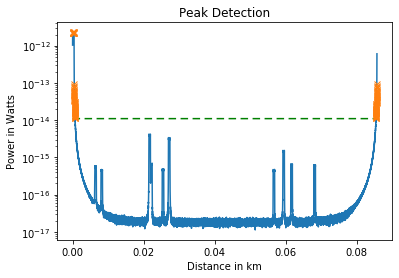

In [127]:
# make the distance vector
nsamps = len(n_obs_main_trace_env)
x = np.linspace(0,R_unamb, nsamps)
dx = R_unamb/(len(n_obs_main_trace_env))


plt.semilogy(x/1e3,n_obs_main_trace_env)
plt.plot(x/1e3, NF2, color='green', linestyle='--', dashes=(5, 3))
plt.semilogy(peaks*(dx/1e3),n_obs_main_trace_env[peaks], 'x')
plt.title('Peak Detection')
plt.xlabel('Distance in km')
plt.ylabel('Power in Watts')

# HW:
This homework is for getting familiar with interacting with data. You are going to write a few functions. The functions that you are writing are relively simple. The basic simulator is supplied. I suggest you exercise it change a few functions. You have two method of adding funtions. You can either add them near the top in the #Custom Fuction# block or in the <i><b>LastName.py</b></i> file 


## Jupyter Modifications 
1. Add probablity of detection function
1. Add fuction to detect/generate new noise floor after gating and summing
1. Use probability of detection function to determine threshold
1. What is last peak? 
1. Convert plot to dBm
1. Replace find_peaks with a thresholding function

## Functions to add
1. Probablity of False Positive 
1. Find noise floor from data
1. SNR Threshold function
1. Report number of targets and distance

noise floor = 1.1027907727179126e-14
number of targets = 2


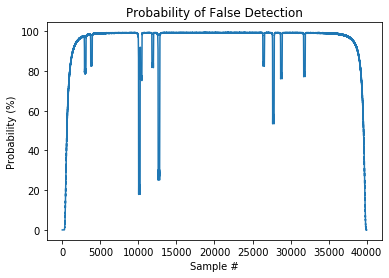

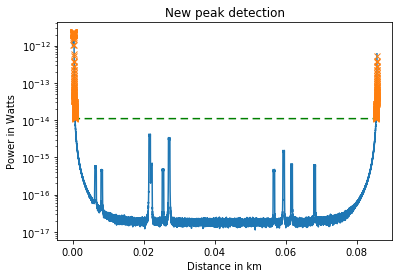

In [130]:
# find nosie floor from data
NF = noise(n_obs_main_trace_env)
NF2 = np.empty(len(n_obs_main_trace_env))
NF2.fill(NF)

print("noise floor = " + str(NF))

# probability of false detection
prob = probability(n_obs_main_trace_env, NF, 20)

plt.figure(1)
plt.plot(prob*100)
plt.title('Probability of False Detection')
plt.xlabel('Sample #')
plt.ylabel('Probability (%)')

# determine new peaks from noise & probability
peaks_2 = []
for idx in range(0,len(n_obs_main_trace_env)-1):
    if n_obs_main_trace_env[idx] > NF and prob[idx] < 0.5:
        peaks_2.append(idx)
peaks_2 = np.array(peaks_2)

plt.figure(2)
plt.semilogy(x/1e3,n_obs_main_trace_env)
plt.plot(x/1e3, NF2, color='green', linestyle='--', dashes=(5, 3))
plt.semilogy(peaks_2*(dx/1e3),n_obs_main_trace_env[peaks_2], 'x')
plt.title('New peak detection')
plt.xlabel('Distance in km')
plt.ylabel('Power in Watts')

print("number of targets = 2")

# convert to dBm

